In [111]:
import re
import random
import pandas as pd
import hashlib

In [112]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [113]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure Kubernetes Learning Path,9.789633,4.894816,2
JavaScript Concepts,263.569499,3.712246,71
FSLogix,384.053462,16.002228,24
Search Engine Optimization,543.411788,90.568631,6
Powershell,554.409528,46.200794,12
Audit Report Tracker (Sharepoint List),724.186856,45.261678,16
Azure Functions + Visual Studio,754.445434,53.888960,14
Email Auth and Security,796.762034,61.289387,13
DNS,898.663030,56.166439,16
OData,905.127554,60.341837,15


# Histogram

39856.57


<Axes: >

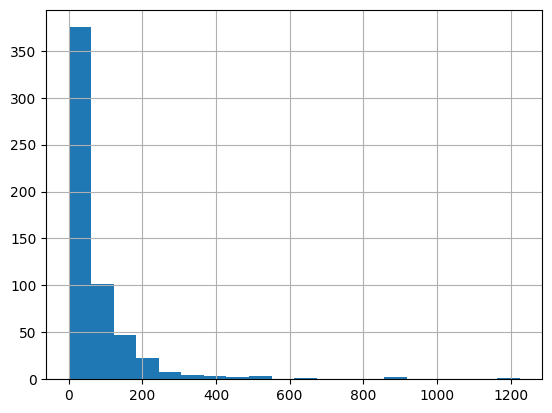

In [114]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [115]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [116]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 572


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
568,Open Source/GitHub,Merge Conflict\n\nA situation where changes fr...,a20e814efc89ca0751fd61447922c74f,1224.243923,155.805632,1224.243923,3427.723908,0.401988
527,Network Mapping,Passive Network Mapping\n\nDefinition: The pro...,1d7c0c4f61ca9611711b89013b24f449,917.612978,150.900365,917.612978,3168.907663,0.412623
496,Open Source/GitHub,Upstream Repository\n\nThe original repository...,bac89aad842f10983309989ba0eae014,886.623933,155.805632,1224.243923,3427.723908,0.401988
512,Azure Functions + PP365,Function URL\nThe endpoint URL assigned to an ...,2f34def14780bef5e7f4933776a0e00a,626.184642,102.553293,626.184642,4409.791619,0.905898
508,Azure Functions + PP365,Azure Resource Manager (ARM) Templates\nJSON f...,55f4e6729328a01289468a2cd32e2e0a,526.363883,102.553293,626.184642,4409.791619,0.905898
480,PEP 8,Breaking Long Lines with Parentheses: Use pare...,6f59564e6d13457d312d4cedff8276b0,492.616847,127.271164,492.616847,3054.507924,0.151378
511,Azure Functions + PP365,Remote Debugging\nThe ability to debug Azure F...,c464c1050c838052d6427e406caca7c3,490.176233,102.553293,626.184642,4409.791619,0.905898
542,Network Mapping,Buffer Overflow\n\nDefinition: A vulnerability...,aa8e33713e937f14d63eb8a62f42596f,474.374593,150.900365,917.612978,3168.907663,0.412623
561,WSL + Kali Linux,You can also invoke Linux commands from PowerS...,28044c53153ff8be773479d3e0e01243,464.286469,132.703296,464.286469,3582.988991,0.719413
514,WSL + Kali Linux,WSL Interop\nWSL allows interoperability betwe...,0ec5e63a9b7a9ea70c5b6a4f7f6b6c3f,396.685822,132.703296,464.286469,3582.988991,0.719413


# Headers with fewest notes first

In [117]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [118]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [119]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [120]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [121]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [122]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [123]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Max

In [124]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [125]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [126]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [127]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
568,Open Source/GitHub,Merge Conflict\n\nA situation where changes fr...,a20e814efc89ca0751fd61447922c74f,1224.243923,155.805632,1224.243923,3427.723908,0.401988
527,Network Mapping,Passive Network Mapping\n\nDefinition: The pro...,1d7c0c4f61ca9611711b89013b24f449,917.612978,150.900365,917.612978,3168.907663,0.412623
496,Open Source/GitHub,Upstream Repository\n\nThe original repository...,bac89aad842f10983309989ba0eae014,886.623933,155.805632,1224.243923,3427.723908,0.401988
512,Azure Functions + PP365,Function URL\nThe endpoint URL assigned to an ...,2f34def14780bef5e7f4933776a0e00a,626.184642,102.553293,626.184642,4409.791619,0.905898
508,Azure Functions + PP365,Azure Resource Manager (ARM) Templates\nJSON f...,55f4e6729328a01289468a2cd32e2e0a,526.363883,102.553293,626.184642,4409.791619,0.905898
480,PEP 8,Breaking Long Lines with Parentheses: Use pare...,6f59564e6d13457d312d4cedff8276b0,492.616847,127.271164,492.616847,3054.507924,0.151378
511,Azure Functions + PP365,Remote Debugging\nThe ability to debug Azure F...,c464c1050c838052d6427e406caca7c3,490.176233,102.553293,626.184642,4409.791619,0.905898
542,Network Mapping,Buffer Overflow\n\nDefinition: A vulnerability...,aa8e33713e937f14d63eb8a62f42596f,474.374593,150.900365,917.612978,3168.907663,0.412623
561,WSL + Kali Linux,You can also invoke Linux commands from PowerS...,28044c53153ff8be773479d3e0e01243,464.286469,132.703296,464.286469,3582.988991,0.719413
514,WSL + Kali Linux,WSL Interop\nWSL allows interoperability betwe...,0ec5e63a9b7a9ea70c5b6a4f7f6b6c3f,396.685822,132.703296,464.286469,3582.988991,0.719413


In [128]:
existing_cards['age'].mean()

69.67931951811637